# A joint multilevel model for CAR 
Using MVS.CARLeroux
## Common Markov Gaussian Random Field
 $$ [P , S ] = [P | GMRF_p] [ S | GMRF_s] $$

In [1]:
## Import code:
setwd('/apps/external_plugins/biospytial_rwrapper/biospytial.rwrapper/R/')
rm(list=ls())                                                                                     
source("init_data.R")

Loading required package: MASS
Loading required package: Rcpp

Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
## Extract the response variables
Y = TDF %>% select(Pinophyta,Abies)
## Extract the formula
formula_presence
rhs <- ~ Elevationm + MeanTempm
X <- model.frame(rhs,DataFrame,na.action='na.pass')

species ~ Elevationm + MeanTempm

In [3]:
K = dim(M_bis)[1]
trials <- matrix(rep(1.0,K*2), ncol=2)

In [4]:
burnin = 50000
n.sample = 100000
thin = 50
model3 <- MVS.CARleroux(cbind(Pinophyta,Abies) ~ Elevationm + MeanTempm, 
                        family = 'binomial',
                        trials=trials,
                        W=M_bis,
                        rho = 1,
                        burnin = burnin,
                        n.sample = n.sample,
                        data = DataFrame
                         )

Setting up the model.
Generating 50000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  4846.2 seconds.


In [5]:
## model
model3$modelfit

DIC           p.d          WAIC           p.w          LMPL 
   1219.58881     537.54723    1195.91816     366.34037    -847.14355 
loglikelihood 
    -72.24717

In [6]:
model3$summary.results

,Median,2.5%,97.5%,n.sample,% accept,n.effective,Geweke.diag
Pinophyta - (Intercept),-8.3626,-19.8365,-6.1682,50000,46.6,5.9,2.8
Pinophyta - Elevationm,0.0002,-0.0004,0.0009,50000,46.6,377.1,-2.3
Pinophyta - MeanTempm,-0.0009,-0.0020,-0.0001,50000,46.6,131.6,3.3
Abies - (Intercept),-20.6399,-39.4927,-13.7960,50000,46.6,8.8,10.1
Abies - Elevationm,0.0011,-0.0002,0.0031,50000,46.6,284.7,-8.3
Abies - MeanTempm,-0.0006,-0.0022,0.0006,50000,46.6,307.3,5.7
Sigma11,50.7336,32.7747,260.2835,50000,100.0,2.6,-1.8
Sigma22,101.9875,38.9490,328.0166,50000,100.0,2.5,-5.3
rho,1.0000,1.0000,1.0000,NA,NA,NA,NA


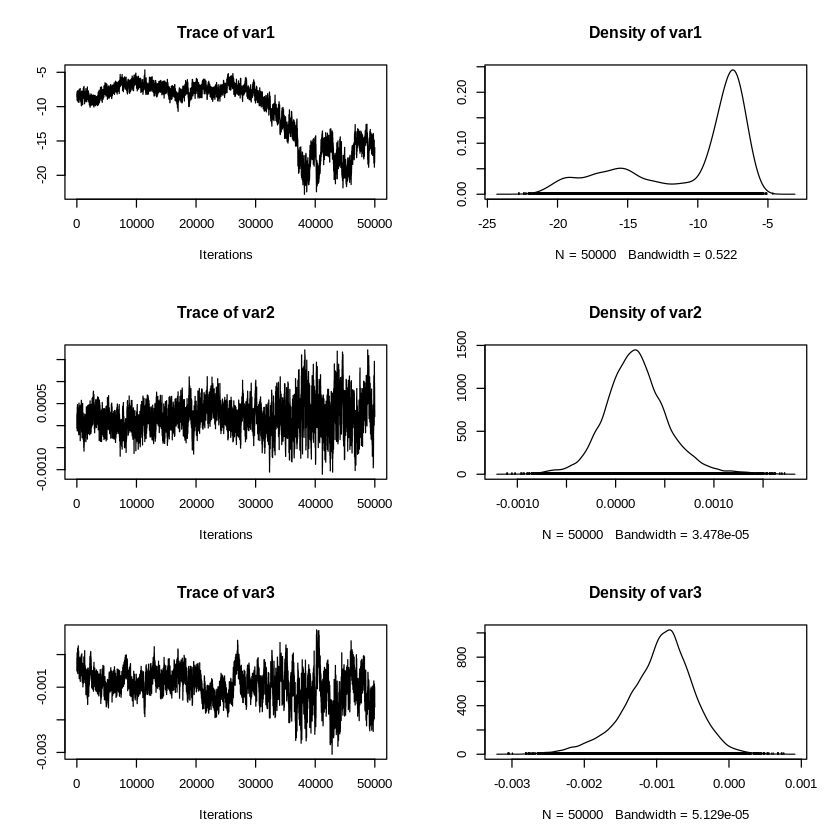

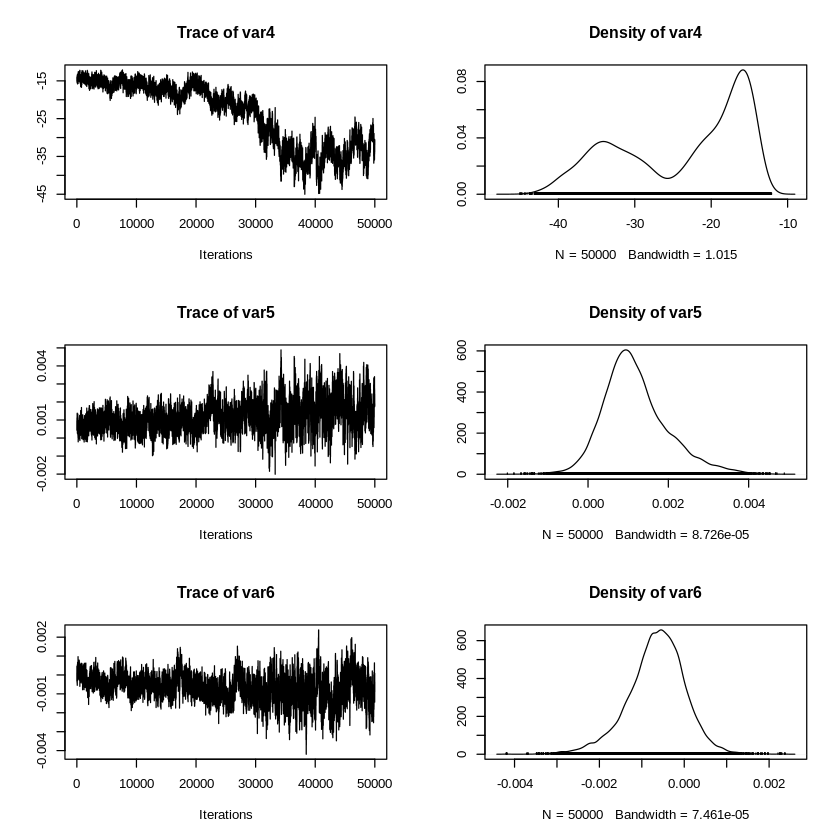

In [7]:
plot(model3$samples$beta)

## Generate datasets. several columns for summary stats

In [8]:
getUpperLowerCI <- function(fitted_sample,prefix="",MARGIN=1){
    fp = partial(quantile,probs=c(0.025,0.5,0.975))
    quants =apply(X = fitted_sample,FUN = fp,MARGIN)
    mfitt = apply(fitted_sample,mean,MARGIN = MARGIN)
    vfitt = apply(fitted_sample,var,MARGIN = MARGIN)
    new_data = cbind(t(quants),mfitt,vfitt)
    l = as.list(c("q025","median","q0975","mean","variance"))
    nnames = lapply(l,function (x){return(paste(prefix,x,sep = '_'))})
    colnames(new_data) = nnames
    return(new_data)
}

In [9]:
sample_fitted <- t(model3$samples$fitted)

In [22]:
dim(PhiS)

[1] 4060    5

In [10]:
nK <- dim(TDF)[1]
sS <- sample_fitted[1:nK,]
sP <- sample_fitted[(nK +1) : (2*nK), ]
S <- getUpperLowerCI(sS,prefix = 'S')
P <- getUpperLowerCI(sP,prefix = 'P')

In [11]:
sample_phi <- t(model3$samples$phi)
sPhiS <- sample_phi[1:nK,]
sPhiP <- sample_phi[(nK +1) : (2*nK), ]
PhiS <- getUpperLowerCI(sPhiS,prefix='PhiS')
PhiP <- getUpperLowerCI(sPhiP,prefix='PhiP')

## Sample the posterior

In [12]:
post.sample_p = data.frame(model3$samples$fitted)
pss  <- post.sample_p %>% mutate_all(function(p) rbernoulli(1,p))
## divide samples for S and P according to the order given up
pred.S <- pss[,1:nK]
pred.P <- pss[,(nK +1) : (2*nK) ]
sumps <- colSums(pred.S)
sumpp <- colSums(pred.P)
nsample <- nrow(pred.S)
PX <- sumps / nsample

#nsample <- nrow(pred.P)
PY <- sumpp / nsample
PXY <- PX * PY
samples <- cbind(PX,PY,PXY)

## Save to posterity

In [17]:
data <- cbind(TDF$cellids,PhiP,PhiS,P,S,samples)

In [18]:
head(data)

,,PhiP_q025,PhiP_median,PhiP_q0975,PhiP_mean,PhiP_variance,PhiS_q025,PhiS_median,PhiS_q0975,PhiS_mean,⋯,P_mean,P_variance,S_q025,S_median,S_q0975,S_mean,S_variance,PX,PY,PXY
X1,233546,-7.072119,2.92412281,14.77399,3.10289220,27.62005,-35.96638,-9.187895,7.752337,-10.021744,⋯,0.0298430393,9.682851e-03,2.512178e-24,2.932221e-09,3.425936e-02,5.266197e-03,1.826318e-03,0.01316,0.01122,0.0001476552
X2,233547,-7.556474,5.07499571,22.89355,5.85219673,54.62986,-44.91780,-10.804136,13.244089,-11.631782,⋯,0.0006014283,1.153664e-04,8.480618e-34,2.206205e-13,3.977552e-04,1.003212e-03,2.821223e-04,0.00368,0.00030,0.0000011040
X3,233548,-10.061142,1.20954925,13.43406,1.26234558,30.60803,-32.89115,-8.091397,7.257646,-9.174576,⋯,0.0156402442,4.405715e-03,1.213642e-23,4.916770e-09,8.360413e-03,2.463883e-03,7.281943e-04,0.00096,0.00126,0.0000012096
X4,233549,-11.466967,3.22206870,20.32568,3.58456495,56.12662,-40.62681,-9.862636,11.986610,-10.509941,⋯,0.0002069126,1.494132e-05,1.571988e-33,1.078889e-13,1.200574e-05,2.705551e-04,8.945949e-05,0.00012,0.00008,0.0000000096
X5,233550,-11.786057,0.02484498,10.99846,-0.07802088,30.08414,-30.96576,-7.465797,6.408228,-8.804521,⋯,0.0140276304,3.907292e-03,2.696732e-22,6.924625e-09,5.581779e-03,2.421487e-03,7.314668e-04,0.00456,0.07002,0.0003192912
X6,233551,-12.450041,1.82856410,17.84775,2.05160875,53.09575,-37.79257,-9.501534,10.676740,-10.059669,⋯,0.0015678277,3.454405e-04,4.900914e-33,4.055172e-14,6.798717e-06,7.096013e-05,3.544216e-06,0.00000,0.00006,0.0000000000


In [19]:
file_ = '/outputs/presence_only_models/modelCAR3.csv'
write.csv(data,file_)

## Save fitted samples (P,S)

In [106]:
sample_fitted <- t(model3$samples$fitted)
fitted_chain <- cbind(TDF$cellids,sample_fitted)
file2 <- '/outputs/presence_only_models/modelCAR_model3_fitted_sample.csv'
write.csv(fitted_chain,file2)

In [107]:
sample_phi <- t(model3$samples$phi)
nK <- dim(TDF)[1]

S <- sample_phi[1:nK,]
P <- sample_phi[(nK +1) : (2*nK), ]
chain = cbind(TDF$cellids,S)
file_ = '/outputs/presence_only_models/modelCAR_model3_phi_S.csv'
write.csv(chain,file_)
chain = cbind(TDF$cellids,P)
file_ = '/outputs/presence_only_models/modelCAR_model3_phi_P.csv'
write.csv(chain,file_)


 num [1:4060] 5.30e-05 1.89e-05 2.16e-07 2.14e-06 2.15e-06 ...


In [23]:
## P and S
## divide samples for S and P according to the order given up
nK <- dim(TDF)[1]
fitted = model3$fitted.values
S <- fitted[1:nK]
P <- fitted[(nK +1) : (2*nK) ]
chain = cbind(TDF$cellids,S,P)
file_ = '/outputs/presence_only_models/modelCAR_model3_fitted.csv'
#write.csv(chain,file_)


[1] 4060

In [110]:
str(model3$samples$Sigma)

 num [1:50000, 1:2, 1:2] 60 60.8 58.7 61.4 57.5 ...


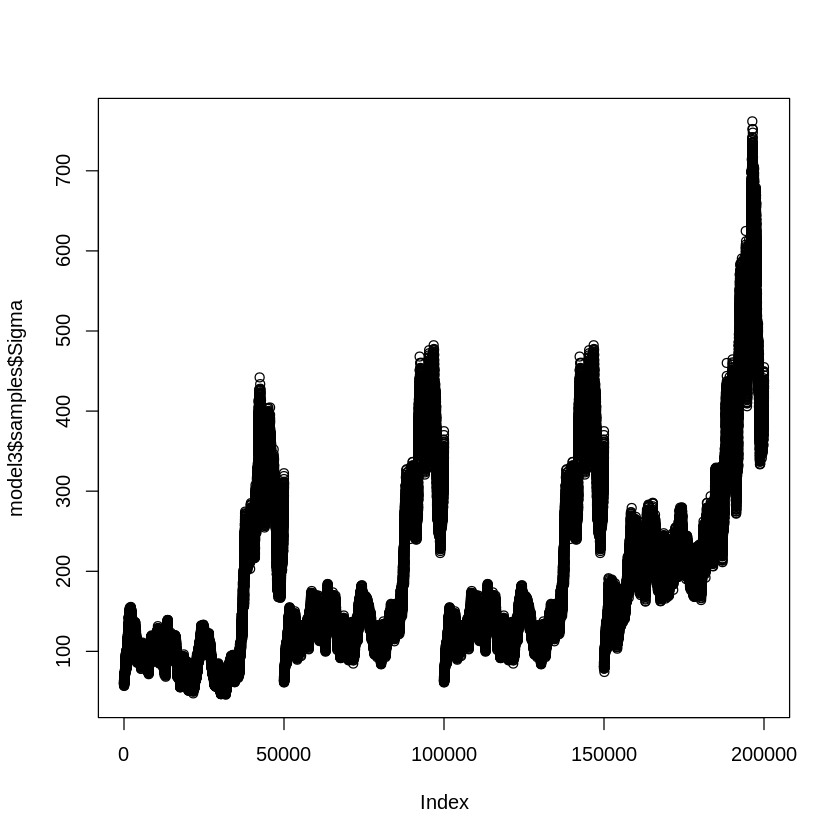

In [111]:
plot(model3$samples$Sigma)